In [1]:
# PROJECT: Computer Vision Project 1

In [2]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [3]:
# Import libraries 
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot
import seaborn as sns
import tensorflow 
print(tensorflow.__version__)
import cv2
import math
import time
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, MaxPool2D, GlobalMaxPooling2D, Input, Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model 
from keras import optimizers
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.utils.np_utils import to_categorical 
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve, GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger
from keras.layers import Convolution2D 
from keras.utils import np_utils
from keras import layers
from keras import regularizers
from keras.models import Model
from keras.models import Sequential, load_model
from sklearn import preprocessing
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
import skimage.io as io
from sklearn.metrics import classification_report, confusion_matrix
import glob
# GLOBAL VARIABLES
scale = 71
seed = 7

2.8.2


In [4]:
# Part A
# DOMAIN: Botanical Research
# PROJECT OBJECTIVE: To create a classifier capable of determining a plant's species from a photo.

In [5]:
# 1. Import and Understand the data 

In [6]:
# Q1 A
# Extract ‘plant-seedlings-classification.zip’ into new folder (unzipped) using python.

In [7]:
# Solution 
base_path = '/content/drive/My Drive/'
train_path = base_path+"Data/plant-seedlings-classification.zip"
extract_path = base_path+'Data/Extracted/' 
save_extracted = base_path+'Data/Save/'

In [8]:
# Extracting the zip files 
from zipfile import ZipFile
with ZipFile(train_path, 'r') as zip:
  zip.extractall(extract_path) 

In [9]:
# Q1 B
# Map the images from train folder with train labels to form a DataFrame.

In [10]:
# Solution 
pathToTrain = "/content/drive/My Drive/Data/Extracted/train"
pathtToTest = "/content/drive/My Drive/Data/Extracted/test" 

In [11]:
path = '/content/drive/My Drive/Data/Extracted/train/*/*.png'
files =  glob.glob(path) 
trainImg = []   
trainLabel = []
cnt = 1
num = len(files)
for img in files:  
  print(str(cnt) + "/" + str(num), end="\r")
  trainImg.append(cv2.resize(cv2.imread(img), (scale, scale))) 
  trainLabel.append(img.split('/')[-2]) 
  cnt += 1
trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

In [12]:
len(trainImg)

4750

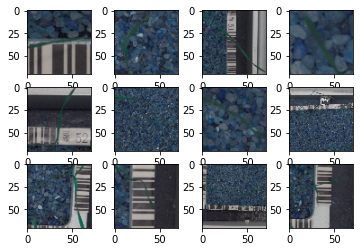

In [13]:
# Checking a few images 
for i in range(12):
    plt.subplot(3, 4, i + 1) # subplot(row, column, index)
    plt.imshow(trainImg[i])

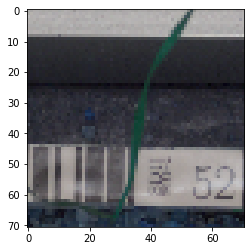

In [14]:
plt.imshow(trainImg[4])

In [15]:
im = trainImg[4]
im.shape

(71, 71, 3)

In [16]:
# Q1 C
# Write a function that will select n random images and display images along with its species.

In [17]:
# Solution
file_path = '/content/drive/My Drive/Data/Extracted/train'
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tensorflow.strings.split(file_path, os.path.sep)
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tensorflow.argmax(one_hot)

In [18]:
batch_size = 32
img_height = 71
img_width = 71

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tensorflow.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tensorflow.image.resize(img, [img_height, img_width])

In [19]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tensorflow.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [20]:
import pathlib
data_root_orig = '/content/drive/My Drive/Data/Extracted/train'
data_dir = pathlib.Path(data_root_orig)

train_ds = tensorflow.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.10,
  subset="training",
  seed=7,
  image_size=(img_height, img_width ),
  batch_size=batch_size)

Found 4750 files belonging to 12 classes.
Using 4275 files for training.


In [21]:
class_names = train_ds.class_names
print(class_names)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [22]:
val_ds = tensorflow.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.10,
  subset="validation",
  seed=7, 
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4750 files belonging to 12 classes.
Using 475 files for validation.


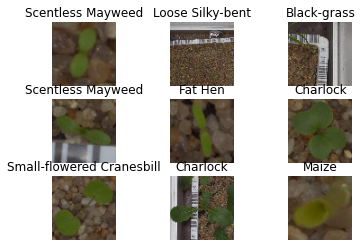

In [23]:
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]]) 
    plt.axis("off")

In [24]:
# 2. Data Pre-Processing 

In [25]:
# Q2 A
# Create X & Y from the DataFrame.

In [26]:
# Solution 
X = np.zeros((len(trainImg), scale, scale, 3))
X.shape

(4750, 71, 71, 3)

In [27]:
Y = np.zeros(trainLabel.shape)
Y.shape

(4750, 1)

In [28]:
# Q2 B
# Encode labels of the images

Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes: 12


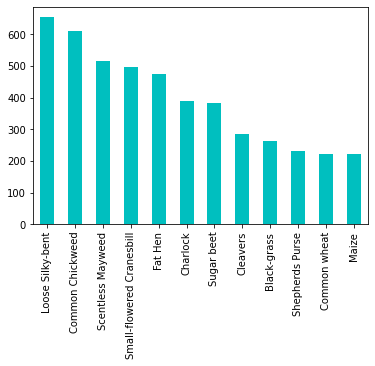

In [29]:
# Solution 
le = preprocessing.LabelEncoder()
le.fit(trainLabel[0])
print("Classes: " + str(le.classes_))
encodeTrainLabels = le.transform(trainLabel[0])
# Make labels categorical
ModifiedTrainLabel = np_utils.to_categorical(encodeTrainLabels)
num_clases = ModifiedTrainLabel.shape[1]
print("Number of classes: " + str(num_clases))

# Plot of label types numbers
trainLabel[0].value_counts().plot(kind='bar', color = 'c')

In [30]:
ModifiedTrainLabel.shape

(4750, 12)

In [31]:
# Q2 C
# Unify shape of all the images

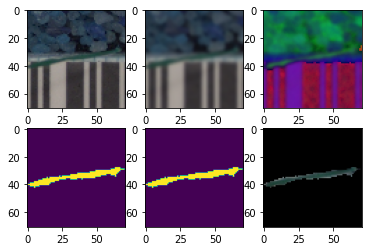

In [32]:
# Solution
# Blurring the image 
ModifiedTrainImg = []
examples = []; getEx = True
for img in trainImg:
  blurImg = cv2.GaussianBlur(img, (5, 5), 0) # Using Gaussian blur 
  hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV) # Convert to HSV image
  lower_green = (25, 40, 50)
  upper_green = (75, 255, 255)
  mask = cv2.inRange(hsvImg, lower_green, upper_green)
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
  mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
  bMask = mask > 0 # Create bool mask
  clear = np.zeros_like(img, np.uint8)  # Create empty image
  clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
  ModifiedTrainImg.append(clear) # Append image without backgroung
  if getEx:
    plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
    plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
    plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
    plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
    plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
    plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
    getEx = False
        
ModifiedTrainImg = np.asarray(ModifiedTrainImg)

In [33]:
ModifiedTrainImg.dtype

dtype('uint8')

In [34]:
ModifiedTrainImg.shape

(4750, 71, 71, 3)

In [35]:
# Q2 D
# Normalise all the images

In [36]:
# Solution
ModifiedTrainImg  = ModifiedTrainImg/255 

In [37]:
#3. Model training

In [38]:
# Q3 A
# Split the data into train and test data.

In [39]:
# Solution
trainX, testX, trainY, testY = train_test_split(ModifiedTrainImg, ModifiedTrainLabel, test_size=0.1, random_state=7, stratify = ModifiedTrainLabel)

In [40]:
# Q3 B
# Create new CNN architecture to train the model.

In [41]:
trainY.shape[1]

12

In [42]:
trainX.shape[1:]

(71, 71, 3)

In [43]:
# For adding randomness and prevent overfitting 
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True  # randomly flip images vertically
    )  
datagen.fit(trainX)

In [44]:
# Solution
# CNN architecture 
input_shape = trainX.shape[1:] # Input shape of input variable 
num_classes = trainY.shape[1] # Target column size

model = Sequential()
seed = 7  
model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape = input_shape, activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_clases, activation='softmax'))

model.summary()

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 67, 67, 64)        4864      
                                                                 
 batch_normalization (BatchN  (None, 67, 67, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 64)        102464    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 31, 31, 64)       256       
 hNormalization)                                                 
                                                        

In [45]:
# Q3 C
# Train the model on train data and validate on test data

In [46]:
# Solution 
annealer = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.4, min_lr=0.00001)
model.fit_generator(datagen.flow(trainX, trainY), epochs=50, validation_data=(testX, testY), callbacks=[annealer]) 


Epoch 1/50
134/134 [==============================] - 21s 55ms/step - loss: 2.4656 - accuracy: 0.2994 - val_loss: 7.8108 - val_accuracy: 0.0611 - lr: 0.0010
Epoch 2/50
134/134 [==============================] - 6s 46ms/step - loss: 1.8542 - accuracy: 0.4000 - val_loss: 8.3185 - val_accuracy: 0.0611 - lr: 0.0010
Epoch 3/50
134/134 [==============================] - 6s 44ms/step - loss: 1.6481 - accuracy: 0.4547 - val_loss: 8.4528 - val_accuracy: 0.0611 - lr: 0.0010
Epoch 4/50
134/134 [==============================] - 6s 43ms/step - loss: 1.4637 - accuracy: 0.4989 - val_loss: 5.7930 - val_accuracy: 0.0821 - lr: 0.0010
Epoch 5/50
134/134 [==============================] - 7s 49ms/step - loss: 1.3110 - accuracy: 0.5680 - val_loss: 1.0525 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 6/50
134/134 [==============================] - 6s 44ms/step - loss: 1.1902 - accuracy: 0.5991 - val_loss: 0.9296 - val_accuracy: 0.6842 - lr: 0.0010
Epoch 7/50
134/134 [==============================] - 6s 43ms/s

In [47]:
print(model.evaluate(trainX, trainY))  # Evaluate on train set

134/134 [==============================] - 2s 13ms/step - loss: 0.2073 - accuracy: 0.9223
[0.20728799700737, 0.9223392009735107]


In [48]:
print(model.evaluate(testX, testY))  # Evaluate on test set

15/15 [==============================] - 0s 11ms/step - loss: 0.2131 - accuracy: 0.9179
[0.21314877271652222, 0.917894721031189]


In [50]:
# Q3 D  
# Select a random image and print actual label and predicted label for the same.

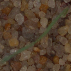

The shape of image to be predicted is:'(237, 237, 3)'
The shape of image to be predicted after expanding the dimensions is:'(1, 71, 71, 3)'


In [51]:
# Solution 
img_path =  "/content/drive/My Drive/Data/Extracted/test/0a64e3e6c.png"
from google.colab.patches import cv2_imshow
img_pred_1 = cv2.imread(img_path)
img_pred_1_resize = cv2.resize(img_pred_1,(71,71), interpolation = cv2.INTER_CUBIC)
cv2_imshow(img_pred_1_resize)
img_predict_1 = np.expand_dims(img_pred_1_resize, axis=0)
print(f"The shape of image to be predicted is:'{img_pred_1.shape}'")
print(f"The shape of image to be predicted after expanding the dimensions is:'{img_predict_1.shape}'")

In [52]:
predicted = np.argmax(model.predict(img_predict_1))

In [53]:
predicted

5

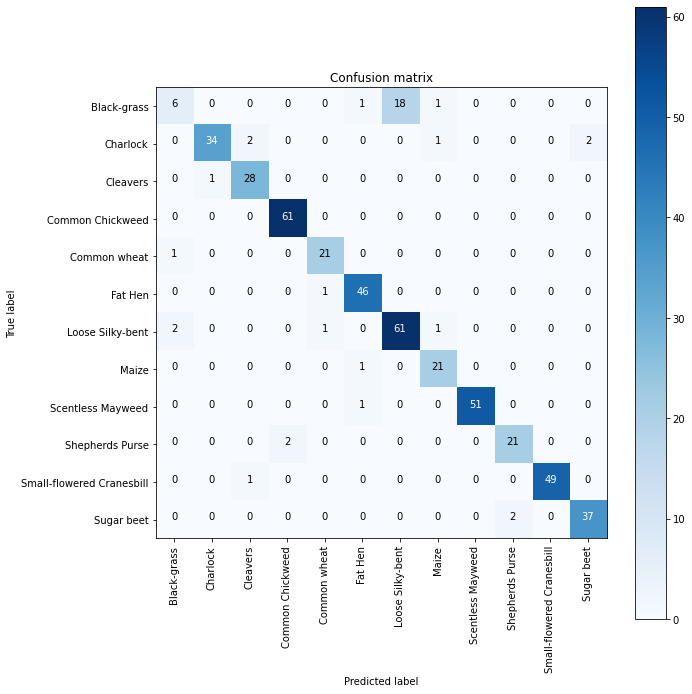

In [54]:
# Confusion matrix helps in ascertaining the model veracity. 
# It shows the efficiency of trained model in correctly predicting the test data. 
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
predY = model.predict(testX)
predYClasses = np.argmax(predY, axis = 1) 
trueY = np.argmax(testY, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(trueY, predYClasses) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = le.classes_) 

In [55]:
predY = model.predict(testX)
print(classification_report(testY.argmax(axis=1), predY.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.67      0.23      0.34        26
           1       0.97      0.87      0.92        39
           2       0.90      0.97      0.93        29
           3       0.97      1.00      0.98        61
           4       0.91      0.95      0.93        22
           5       0.94      0.98      0.96        47
           6       0.77      0.94      0.85        65
           7       0.88      0.95      0.91        22
           8       1.00      0.98      0.99        52
           9       0.91      0.91      0.91        23
          10       1.00      0.98      0.99        50
          11       0.95      0.95      0.95        39

    accuracy                           0.92       475
   macro avg       0.91      0.89      0.89       475
weighted avg       0.91      0.92      0.91       475



In [57]:
# Part B
# Botanical Research

In [58]:
# Objective: To experiment with various approaches to train an image classifier to predict type of flower from the image.

In [59]:
# 1. Import and Understand the data

In [60]:
# Q1 A
# Import and read oxflower17 dataset from tflearn and split into X and Y while loading.

In [61]:
!pip install tflearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 107 kB 38.1 MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127299 sha256=8d4e641a27a009e75876a99f1f6b94f508d78cdb01ba93c87934afe03f16da18
  Stored in directory: /root/.cache/pip/wheels/5f/14/2e/1d8e28cc47a5a931a2fb82438c9e37ef9246cc6a3774520271
Successfully built tflearn


In [62]:
import tflearn

Instructions for updating:
non-resource variables are not supported in the long term


In [63]:
import tflearn.datasets.oxflower17 as oxflower17

In [64]:
def load_data(dirname="17flowers", resize_pics=(224, 224), shuffle=True,
    one_hot=False):
    dataset_file = os.path.join(dirname, '17flowers.pkl')
    if not os.path.exists(dataset_file):
        dirname = 'C:/Users/anaconda35/Lib/site-packages/tflearn/datasets/17flowers'
        tarpath = maybe_download("17flowers.tgz",
                                 "http://www.robots.ox.ac.uk/~vgg/data/flowers/17/",dirname)

    x, y = build_image_dataset_from_dir(os.path.join(dirname, 'jpg/'),
                                        dataset_file=dataset_file,
                                        resize=resize_pics,
                                        filetypes=['.jpg', '.jpeg'],
                                        convert_gray=False,
                                        shuffle_data=shuffle,
                                        categorical_Y=one_hot)

    return x, y

In [65]:
x, y = oxflower17.load_data()

100.0% 60276736 / 60270631


Succesfully downloaded 17flowers.tgz 60270631 bytes.
File Extracted
Starting to parse images...
Parsing Done!


In [66]:
# Q1 B
# Print Number of images and shape of the images.

In [67]:
# Solution 
# Number of images 
len(x)

1360

In [68]:
print(x.shape)

(1360, 224, 224, 3)


In [69]:
# Q1 C
# Print count of each class from y.

In [70]:
# Solution 
print(y.shape)

(1360,)


In [71]:
print("Total labels: {}".format(len(np.unique(y))))
print("Labels: {}".format(y))

Total labels: 17
Labels: [11  5  4 ...  5 15 14]


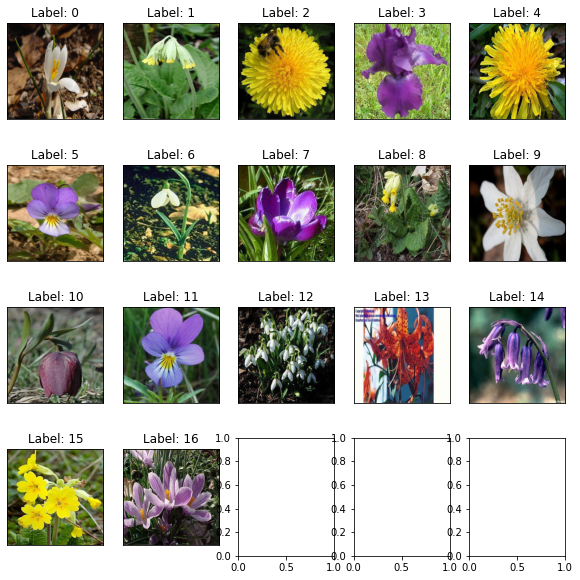

In [72]:
# Displaying an image from each category
cols = 5
rows = int(np.ceil(len(np.unique(y))/cols))

fig, ax = plt.subplots(rows, cols, figsize=(10,10))
for i in np.unique(y):
  col = i % 5
  row = int(i/5)

  ax[row][col].imshow(x[i])
  ax[row][col].tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
  ax[row][col].set_title(f"Label: {i}",{'fontsize':12})
plt.show() 

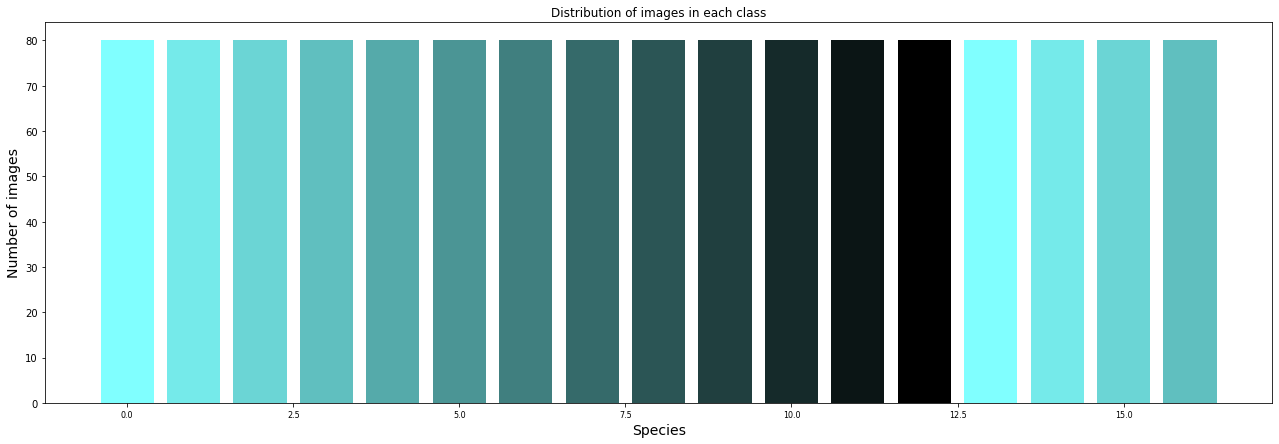

In [73]:
values =[]
labels=[]
for label in set(y):
  values.append(len(x[y == label]))
  labels.append(label)

values.sort()

code=np.arange(0,13,1)
data_normalizer = matplotlib.colors.Normalize()
color_map = matplotlib.colors.LinearSegmentedColormap(
    "my_map",
    {
        "red": [(0, 0, 0.5),
                (1.0, 0, .5)],
        "green": [(0, 0.5, 1.0),
                  (1.0, 0, 0)],
        "blue": [(0, 1.0, 1.0),
                 (1.0, 0, 0)]
    }
)

fig, ax = plt.subplots(figsize=(22,7))
ax.bar(labels, values, color=color_map(data_normalizer(code)))
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 10)
plt.xlabel("Species", fontsize = 14)
plt.ylabel("Number of images", fontsize = 14)
plt.title("Distribution of images in each class", fontsize=12)
plt.show()

In [74]:
# Observation 
# The number of images in each class is equal 

In [75]:
# Q2 A
# Display 5 random images

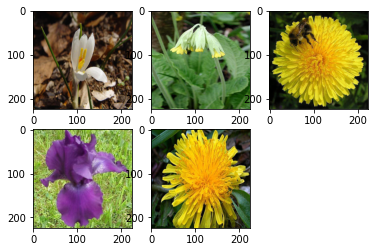

In [76]:
# Solution 
# Displaying 5 random images  
for i in range(5):
    plt.subplot(2, 3, i + 1) # subplot(row, column, index)
    plt.imshow(x[i])

In [77]:
# Q2 B
# Select any image from the dataset and assign it to a variable.

In [78]:
# Solution 
image1 = x[50]

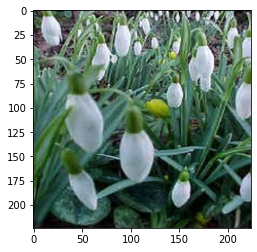

In [79]:
plt.imshow(image1)

In [80]:
# Q2 C
# Transform the image into grayscale format and display the same.

In [81]:
image1.shape

(224, 224, 3)

In [82]:
row = 224
column = 224
for i in range(row):
    for j in range(column):
      image1[i, j] = sum(image1[i, j]) * 0.33

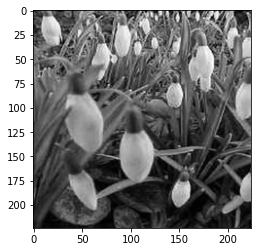

In [83]:
plt.imshow(image1)

In [84]:
image1.shape

(224, 224, 3)

In [85]:
# Q2 D
# Apply a filter to sharpen the image and display the image before and after sharpening.

In [86]:
def sharpen_image(image):
  image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
  image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
  return image_sharp

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


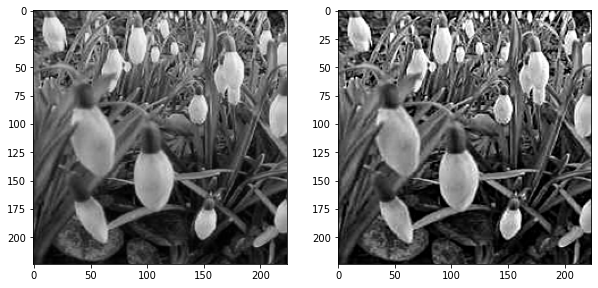

In [87]:
image = image1
image_sharpen = sharpen_image(image)
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(image)
axs[1].imshow(image_sharpen)


In [88]:
# Q2 E
# Apply a filter to blur the image and display the image before and after blur.

In [89]:
# Solution 
def blurred_image(image):
  image_blurred = cv2.GaussianBlur(image1, (0, 0), 3)
  return image_blurred 

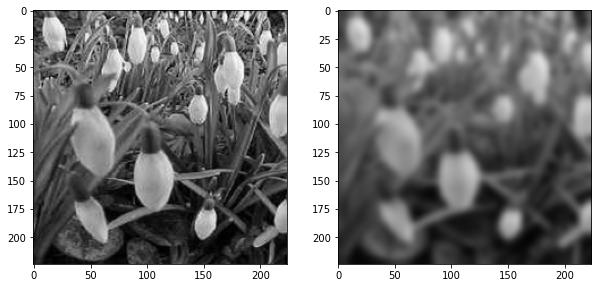

In [90]:
image = image1
image_blurred = blurred_image(image)
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(image)
axs[1].imshow(image_blurred)

In [91]:
# Q2 F
# Display all the 4 images from above questions besides each other to observe the difference.

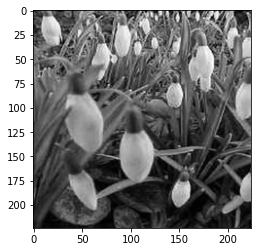

In [92]:
# Solution
plt.imshow(x[50])

In [93]:
image1 = x[50]
img = image1

In [94]:
img.shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


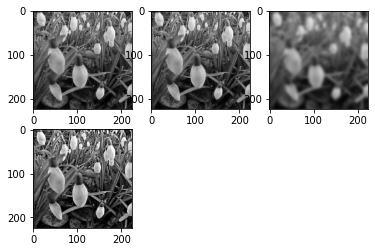

In [95]:
image_segment = cv2.bitwise_and(img, img) 
image_blurred = cv2.GaussianBlur(img, (0, 0), 3)
image_sharp = cv2.addWeighted(img, 1.5, image_blurred, -0.5, 0) 
plt.subplot(2, 3, 1); plt.imshow(img) 
plt.subplot(2, 3, 2); plt.imshow(image_segment)  
plt.subplot(2, 3, 3); plt.imshow(image_blurred)  
plt.subplot(2, 3, 4); plt.imshow(image_sharp)     

In [96]:
# 3. Model training and Tuning:

In [97]:
# Q3 A
# Split the data into train and test with 80:20 proportion

In [98]:
# Solution
# Before splitting, lets do some pre-processing on the images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


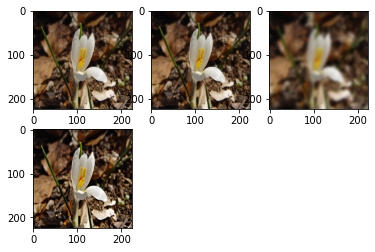

In [99]:
# Solution
examples = []; getEx = True
for img in x:
  image_segment = cv2.bitwise_and(img, img) 
  image_blurred = cv2.GaussianBlur(img, (0, 0), 3)
  image_sharp = cv2.addWeighted(img, 1.5, image_blurred, -0.5, 0) 
  if getEx:
    plt.subplot(2, 3, 1); plt.imshow(img) 
    plt.subplot(2, 3, 2); plt.imshow(image_segment)  
    plt.subplot(2, 3, 3); plt.imshow(image_blurred)  
    plt.subplot(2, 3, 4); plt.imshow(image_sharp) 
    getEx = False

In [100]:
len(x)

1360

In [101]:
# Normalising the image 
x = x/255

In [102]:
x = np.zeros((len(x), 224, 224, 3))
x.shape

(1360, 224, 224, 3)

In [103]:
y.shape

(1360,)

In [104]:
# Splitting the image 
x_train, x_test, y_train, y_test = train_test_split (x, y, test_size=0.2, random_state=7) 

In [105]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((1088, 224, 224, 3), (272, 224, 224, 3), (1088,), (272,))

In [106]:
# Q3 B
# Train a model using any Supervised Learning algorithm and share performance metrics on test data.

In [107]:
# Solution
# Supervised Learning algorithm =  Support Vector Machines 

In [108]:
image1.shape

(224, 224, 3)

In [109]:
image1 = image1.ravel()
image1.shape

(150528,)

In [110]:
# Converting the 4D array to 2D so that it is compatible with SVM 
x2 = np.reshape(x, (1360, 150528))

In [111]:
x2_train, x2_test, y_train, y_test = train_test_split (x2, y, test_size=0.2, random_state=7) 

In [112]:
x2_train.shape, x2_test.shape, y_train.shape, y_test.shape

((1088, 150528), (272, 150528), (1088,), (272,))

In [113]:
from sklearn.svm import SVC
svc = SVC() 
svc.fit(x2_train, y_train) 
print("Accuracy on training set: {:.2f}".format(svc.score(x2_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(x2_test, y_test))) 

Accuracy on training set: 0.06
Accuracy on test set: 0.04


In [115]:
# Observation 
# Using supervised learning classification method, the accuracy score on test data is a paltry 4%. The model holds no relevance for the dataset. 

In [116]:
# Q3 C
# Train a model using Neural Network and share performance metrics on test data.

In [117]:
# Solution
num_classes = 17
y_train = to_categorical(y_train, num_classes=17)
y_test = to_categorical(y_test, num_classes=17)

In [118]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [119]:
y_train.shape, y_test.shape

((1088, 17), (272, 17))

In [120]:
x.shape

(1360, 224, 224, 3)

In [121]:
x_train, x_test, y_train, y_test = train_test_split (x, y, test_size=0.2, random_state=7) 

In [122]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((1088, 224, 224, 3), (272, 224, 224, 3), (1088,), (272,))

In [123]:
# Q3 D
# Train a model using a basic CNN and share performance metrics on test data

In [124]:
# CNN architecture 
input_shape=(224, 224, 3)
CLASS_NUM = 17
model = Sequential()
seed = 7

# model's Layer[1]
model.add(Convolution2D(128, (3, 3), input_shape = input_shape, activation = 'relu', padding = 'same',))
model.add(BatchNormalization())
model.add(Convolution2D(128, (3, 3), input_shape = input_shape, activation = 'relu', padding = 'same',))
model.add(BatchNormalization())

# Pooling for the model's Layer[1]
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

# model's Layer[2]
model.add(Convolution2D(256, (3, 3), activation = 'relu', padding = 'same',))
model.add(BatchNormalization())
model.add(Convolution2D(256, (3, 3), activation = 'relu', padding = 'same',))
model.add(BatchNormalization())

# Pooling for the model's Layer[2]
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

# model's Layer[3]
model.add(Convolution2D(512, (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(Convolution2D(512, (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())

# Pooling for the model's Layer[3]
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.3))

# Flattening the output data after convolution and pooling. The Data comes from the last 3rd layer
model.add(Flatten())

# Adding Fully Connected Layer
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(CLASS_NUM, activation = 'softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [125]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 128)     3584      
                                                                 
 batch_normalization_8 (Batc  (None, 224, 224, 128)    512       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 224, 224, 128)     147584    
                                                                 
 batch_normalization_9 (Batc  (None, 224, 224, 128)    512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 128)    0         
 2D)                                                             
                                                      

In [126]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor = ['val_accuracy'], verbose = 1, mode = 'max')
earlystop = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)
callbacks_list = [checkpoint, earlystop]
opt = tensorflow.keras.optimizers.Adam(lr=0.000001)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [127]:
y_train = to_categorical(y_train, num_classes=17)
y_test = to_categorical(y_test, num_classes=17)

In [128]:
score_train = model.evaluate(x_train, y_train, verbose = 0)
print(model.metrics_names)
print(score_train)

['loss', 'acc']
[2.8332133293151855, 0.05974265]


In [129]:
score_test = model.evaluate(x_test, y_test, verbose = 0)
print(model.metrics_names)
print(score_test)

['loss', 'acc']
[2.8332133293151855, 0.05514706]


In [130]:
# The accuracy score on test data is a low 5.50% 

In [131]:
# Using transfer learning 

In [132]:
# Here, we will use transfer learning method by employing the VGG16 model

In [133]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import optimizers
model_type = 'vgg16'
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

58900480/58889256 [==============================] - 0s 0us/step


In [134]:
# Freezing the base model
vgg_model.trainable = False

In [135]:
model_tl = tensorflow.keras.Sequential([vgg_model,
                                 tensorflow.keras.layers.GlobalAveragePooling2D(),
                                 tensorflow.keras.layers.Dropout(0.2),
                                 tensorflow.keras.layers.Dense(17, activation="softmax")                                     
                                ])

In [136]:
model_tl.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 17)                8721      
                                                                 
Total params: 14,723,409
Trainable params: 8,721
Non-trainable params: 14,714,688
_________________________________________________________________


In [137]:
base_learning_rate = 0.00001
model_tl.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [139]:
history = model_tl.fit(x_train, y_train, epochs = 50 , validation_data = (x_test, y_test))

Train on 1088 samples, validate on 272 samples
Epoch 1/50
1088/1088 [==============================] - 7s 6ms/sample - loss: 0.4852 - acc: 0.9412 - val_loss: 0.4719 - val_acc: 0.9412
Epoch 2/50
1088/1088 [==============================] - 7s 6ms/sample - loss: 0.4805 - acc: 0.9412 - val_loss: 0.4681 - val_acc: 0.9412
Epoch 3/50
1088/1088 [==============================] - 7s 6ms/sample - loss: 0.4770 - acc: 0.9412 - val_loss: 0.4643 - val_acc: 0.9412
Epoch 4/50
1088/1088 [==============================] - 7s 6ms/sample - loss: 0.4758 - acc: 0.9412 - val_loss: 0.4605 - val_acc: 0.9412
Epoch 5/50
1088/1088 [==============================] - 7s 6ms/sample - loss: 0.4706 - acc: 0.9412 - val_loss: 0.4568 - val_acc: 0.9412
Epoch 6/50
1088/1088 [==============================] - 7s 6ms/sample - loss: 0.4661 - acc: 0.9412 - val_loss: 0.4532 - val_acc: 0.9412
Epoch 7/50
1088/1088 [==============================] - 7s 6ms/sample - loss: 0.4612 - acc: 0.9412 - val_loss: 0.4496 - val_acc: 0.9412
E

In [140]:
cnn_loss_tl, cnn_accuracy_tl = model_tl.evaluate(x_test, y_test, verbose=1)
print('Test loss:', cnn_loss_tl)
print('Test accuracy:', cnn_accuracy_tl)

Test loss: 0.3350013950291802
Test accuracy: 0.9411765


In [141]:
# Observation 
# The VGG16 CNN model exhibited a stellar performance. It can predict the flower species with an accuracy of 94%. 

In [142]:
# Q3 E
# Predict the class/label of image ‘Prediction.jpg’ using best performing model and share predicted label. 

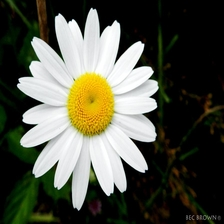

The shape of image to be predicted is:'(224, 224, 3)'
The shape of image to be predicted after expanding the dimensions is:'(1, 224, 224, 3)'


In [143]:
img_path = "/content/drive/My Drive/Prediction.jpg"
from google.colab.patches import cv2_imshow
img_pred = cv2.imread(img_path)
img_pred_resize = cv2.resize(img_pred,(224,224), interpolation = cv2.INTER_CUBIC)
cv2_imshow(img_pred_resize)
img_predict = np.expand_dims(img_pred_resize, axis=0)
print(f"The shape of image to be predicted is:'{img_pred.shape}'")
print(f"The shape of image to be predicted after expanding the dimensions is:'{img_predict.shape}'")

In [144]:
cnn_predict_tl = np.argmax(model_tl.predict(img_predict))

In [145]:
cnn_predict_tl

9